# The Balanced Parentheses Problem
### and a transformer solution (Part 1)

In [1]:
from turing.balanced_parentheses import generate_balanced_parentheses
generate_balanced_parentheses(3)

['((()))', '(()())', '(())()', '()(())', '()()()']

#### A standard solution

In [2]:
def is_balanced(string: str):
    stack = []
    for a in string:
        if a == "(":
            stack.append(a)
        elif a == ")" and len(stack) > 0:
            stack.pop()
        else:
            return False
    return len(stack) == 0

In [3]:
is_balanced("()((()(()))())")

True

#### A turing machine solution

The transition function "delta" takes (state, symbol) and outputs (new state, symbol to write at head, direction to move head)
\
<u> States </u>\
\
I - initial\
R - pass right\
M - find match\
V - validate\
T - true\
F - false\
\
<u> Symbols </u>\
\
B - beginning of tape\
E - end of tape\
\* - blank\
\( - \
\) -

In [4]:
delta = {
    ("I", "B") : ("R", "B",  1),
    ("R", "(") : ("R", "(",  1),
    ("R", ")") : ("M", "*", -1),
    ("R", "*") : ("R", "*",  1),
    ("R", "E") : ("V", "E", -1),
    ("M", "B") : ("F", "*", -1),
    ("M", "(") : ("R", "*",  1),
    ("M", "*") : ("M", "*", -1),
    ("V", "(") : ("F", "*", -1),
    ("V", "*") : ("V", "*", -1),
    ("V", "B") : ("T", "*",  1),
}

In [5]:
# get unique states and symbols
states = set()    
alphabet = set()
for (z, a), (z_next, u, _) in delta.items():
    states.add(z)
    states.add(z_next)
    alphabet.add(a)
    alphabet.add(u)

Simulating the Turing machine solution

In [6]:
def simulate_turing_machine(tape: str, verbose: bool = False):
    head = 0    # head position    
    state = "I"
    n = len(tape)
    cursor = "^"
    pad = " "
    final_states = ["T", "F"]
    while state not in final_states:
        if verbose:
            # print tape
            print("  ", tape, sep="")
            # print machine info
            print(state, " ", pad*head, cursor, pad*(n-head), sep="")    
        # update
        (state, write, move) = delta[(state, tape[head])]        
        # write
        tape = tape[:head] + write + tape[head+1:]
        # move
        head += move
    if state == "T":
        return True
    elif state == "F":
        return False
    else:
        raise Exception("Invalid final state")

tape = "B()((()(()))())E"
simulate_turing_machine(tape, verbose=True)

  B()((()(()))())E
I ^                
  B()((()(()))())E
R  ^               
  B()((()(()))())E
R   ^              
  B(*((()(()))())E
M  ^               
  B**((()(()))())E
R   ^              
  B**((()(()))())E
R    ^             
  B**((()(()))())E
R     ^            
  B**((()(()))())E
R      ^           
  B**((()(()))())E
R       ^          
  B**(((*(()))())E
M      ^           
  B**((**(()))())E
R       ^          
  B**((**(()))())E
R        ^         
  B**((**(()))())E
R         ^        
  B**((**(()))())E
R          ^       
  B**((**((*))())E
M         ^        
  B**((**(**))())E
R          ^       
  B**((**(**))())E
R           ^      
  B**((**(***)())E
M          ^       
  B**((**(***)())E
M         ^        
  B**((**(***)())E
M        ^         
  B**((******)())E
R         ^        
  B**((******)())E
R          ^       
  B**((******)())E
R           ^      
  B**((******)())E
R            ^     
  B**((*******())E
M           ^      
  B**((*******())E
M     

True

Visual representation of the turing machine

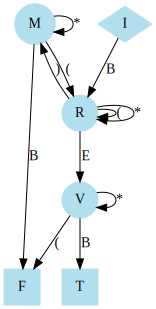

In [7]:
from turing.graph import generate
generate(delta, terminal_states=["T", "F"])

Verify the turing machine definition agrees with the standard algorithm.

In [8]:
from random import sample

for n in range(10):
    for string in generate_balanced_parentheses(n):
        # balanced case
        assert is_balanced(string) == simulate_turing_machine("B" + string + "E"), string
        if n == 0:
            continue
        # random case
        string = "".join(sample(string, 2*n))
        assert is_balanced(string) == simulate_turing_machine("B" + string + "E"), string

#### Now write a neural network to simulate the Turing machine

In [9]:
from math import ceil, log2
import torch
import torch.nn.functional as F
from torch.nn import (
    Linear,
    Parameter
)

In [10]:
# list so we can index
alphabet = list(alphabet)
states = list(states)
a2i = {a: i for i, a in enumerate(alphabet)}
z2i = {z: i for i, z in enumerate(states)}
alphabet, a2i, states, z2i

(['B', '*', ')', '(', 'E'],
 {'B': 0, '*': 1, ')': 2, '(': 3, 'E': 4},
 ['M', 'T', 'V', 'I', 'R', 'F'],
 {'M': 0, 'T': 1, 'V': 2, 'I': 3, 'R': 4, 'F': 5})

In [11]:
T = 100
w_pos = ceil(log2(T))
w_scr = 3
w = len(states) + 2*len(alphabet) + 3*w_pos + w_scr
def Bin(i):
    stringbin = f"{i:0{w_pos}b}"
    return list(map(int, list(stringbin)))
Bin(5)

[0, 0, 0, 0, 1, 0, 1]

##### Lemma C.1

In [12]:
# starting indexes
st_ = 0
sym1_ = len(states)
sym2_ = sym1_ + len(alphabet)
pos1_ = sym2_ + len(alphabet)
pos2_ = pos1_ + w_pos
pos3_ = pos2_ + w_pos
scr_ = pos3_ + w_pos

In [13]:
# example output
def one_alphabet(a):
    o = torch.zeros([len(alphabet)])
    o[a2i[a]] = 1
    return o

def one_states(z):
    o = torch.zeros([len(states)])
    o[z2i[z]] = 1
    return o

def hinput(z: str, a: str, i: int, l: int):
    # decoder inputs for timestep i
    o_st = one_states(z)
    o_sym1 = one_alphabet(a)
    o_sym2 = torch.zeros(len(alphabet))
    o_pos1 = torch.Tensor(Bin(i))
    o_pos2 = torch.Tensor(Bin(l))
    o_pos3 = torch.zeros(w_pos)
    o_scr = torch.zeros(w_scr)
    return (o_st, o_sym1, o_sym2, o_pos1, o_pos2, o_pos3, o_scr)

hinput("M", "(", 2, 3)

(tensor([1., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 1., 0.]),
 tensor([0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 1.]),
 tensor([0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0.]))

In [14]:
ds = len(states)*len(alphabet) # domain size
linear1 = Linear(w, w+ds)
linear2 = Linear(w+ds, w)
upper = torch.zeros((ds, w)) # upper ZxA block of weights1
lower = torch.eye(w)
weight2 = torch.zeros((w, w+ds))
k = 0
for i in range(len(states)):
    for j in range(len(alphabet)):
        # weights 1
        row = torch.zeros(w)        
        row[st_ + i] = 1
        row[sym1_ + j] = 1
        upper[k] = row
        # weights 2
        z, a = states[i], alphabet[j]
        if (z, a) in delta:
            # state transition
            z_next, u, q = delta[(z, a)]
            weight2[st_ + z2i[z_next], k] = 1
            # write symbol
            weight2[sym2_ + a2i[u], k] = 1
            # move            
            weight2[scr_+(q+1)//2, k] = 1
        else:
            # random initialization should be fine since we dont encounter those
            pass    
        #
        k += 1
weight = torch.cat([upper, lower])
linear1.weight = Parameter(weight)
bias = torch.zeros(w+ds)
bias[:ds] = -1
linear1.bias = Parameter(bias)
weight2[pos1_:pos2_, (ds+pos1_):(ds+pos2_)] = torch.eye(w_pos)
weight2[pos2_:pos3_, (ds+pos2_):(ds+pos3_)] = torch.eye(w_pos)
linear2.weight = Parameter(weight2)
linear2.bias = Parameter(torch.zeros_like(linear2.bias))

Test it

In [15]:
l = 4
i = 3
for (z, a), (z_next, u, q) in delta.items():
    h = torch.cat(hinput(z, a, i, l))
    o = linear2(F.relu(linear1(h)))    
    assert torch.equal(one_states(z_next), o[st_:sym1_])
    assert torch.equal(torch.zeros_like(o[sym1_:sym2_]), o[sym1_:sym2_])
    assert torch.equal(one_alphabet(u), o[sym2_:pos1_])
    assert torch.equal(torch.Tensor(Bin(i)), o[pos1_:pos2_])
    assert torch.equal(torch.Tensor(Bin(l)), o[pos2_:pos3_])
    assert torch.equal(torch.zeros_like(o[pos3_:scr_]), o[pos3_:scr_])
    assert torch.equal(torch.Tensor([0, 1, 0]) if q == 1 else torch.Tensor([1, 0, 0]), o[scr_:])

##### Lemma C.2

[Reference for subtraction logic gate](https://www.101computing.net/binary-subtraction-using-logic-gates/)

In [16]:
from turing.networks import FullAdder

# check what it does
for i in range(7):
    for q in [1, -1]:
        if i + q < 0: 
            continue
        if q == 1:
            # add
            b = torch.zeros([w_pos])
            b[w_pos-1] = 1
            cin = 0
        else:
            # subtract, get 2s complement
            b = torch.ones([w_pos])
            b[w_pos-1] = 0
            cin = 1
        a = torch.cat([torch.Tensor(Bin(i)), b, torch.Tensor([cin, 6])])   
        d_in = a.shape[0]
        a = FullAdder(d_in, i=w_pos-1, j=2*w_pos-1, k=2*w_pos)(a)
        a = FullAdder(d_in, i=w_pos-2, j=2*w_pos-2, k=2*w_pos)(a)
        a = FullAdder(d_in, i=w_pos-3, j=2*w_pos-3, k=2*w_pos)(a)
        print(i, q, a[:w_pos])

0 1 tensor([0., 0., 0., 0., 0., 0., 1.], grad_fn=<SliceBackward0>)
1 1 tensor([0., 0., 0., 0., 0., 1., 0.], grad_fn=<SliceBackward0>)
1 -1 tensor([0., 0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)
2 1 tensor([0., 0., 0., 0., 0., 1., 1.], grad_fn=<SliceBackward0>)
2 -1 tensor([0., 0., 0., 0., 0., 0., 1.], grad_fn=<SliceBackward0>)
3 1 tensor([0., 0., 0., 0., 1., 0., 0.], grad_fn=<SliceBackward0>)
3 -1 tensor([0., 0., 0., 0., 0., 1., 0.], grad_fn=<SliceBackward0>)
4 1 tensor([0., 0., 0., 0., 1., 0., 1.], grad_fn=<SliceBackward0>)
4 -1 tensor([0., 0., 0., 0., 0., 1., 1.], grad_fn=<SliceBackward0>)
5 1 tensor([0., 0., 0., 0., 1., 1., 0.], grad_fn=<SliceBackward0>)
5 -1 tensor([0., 0., 0., 0., 1., 0., 0.], grad_fn=<SliceBackward0>)
6 1 tensor([0., 0., 0., 0., 1., 1., 1.], grad_fn=<SliceBackward0>)
6 -1 tensor([0., 0., 0., 0., 1., 0., 1.], grad_fn=<SliceBackward0>)


In [17]:
def arithmetic_setup(a):
    """Add dimensions to hold the subtrahend; copy Bin(l) to pos3:
    """
    d = a.size(dim=0)    
    weight = torch.cat([torch.eye(d), torch.zeros(w_pos, d)])
    bias = torch.zeros(d+w_pos)
    # copy Bin(l) to pos3, the minuend
    for k in range(w_pos):
        weight[pos3_+k, pos2_+k] = 1
    # q's value is encoded in o[scr_:scr_+1]
    # use it to initialize o[w:w+w_pos], the subtrahend
    # case: add
    weight[w:w+w_pos, scr_+1] = torch.zeros([w_pos])
    weight[w+w_pos-1, scr_+1] = 1        
    # case: subtract
    weight[w:w+w_pos-1, scr_] = torch.ones([w_pos-1])
    linear_setup = Linear(d, d+w_pos)       
    linear_setup.weight = Parameter(weight)
    linear_setup.bias = Parameter(bias)
    return linear_setup(a)

In [18]:
def projectaway(a, k):
    """Project to first k dimensions
    """
    d = a.size(dim=0)    
    weight = torch.cat([torch.eye(k), torch.zeros(k, d-k)], dim=1)
    bias = torch.zeros(k)   
    l = Linear(d, k)       
    l.weight = Parameter(weight)
    l.bias = Parameter(bias)
    return l(a)

#### Intermission to simulate

In [19]:
def step(h):
    d = h.size(dim=0)   
    # c.1
    o = linear2(F.relu(linear1(h)))
    # c.2
    o = arithmetic_setup(o)     
    d_in = o.shape[0]  
    for k in range(w_pos-1, -1, -1):
        o = FullAdder(d_in, i=pos3_+k, j=w+k, k=scr_)(o)
    o = projectaway(o, d)
    return o

In [20]:
# initial state and position
z, l = "I", 0
tape = "B()((()(()))())E"

for i in range(T):
    print(f'{i:4}.  {tape}')
    a = tape[l]
    # Method 1
    h = torch.cat(hinput(z, a, i, l))
    h = step(h)    
    # Method 2    
    (z, u, q) = delta[(z, a)]   
    # Compare    
    assert torch.equal(one_states(z), h[st_:sym1_])
    assert torch.equal(one_alphabet(u), h[sym2_:pos1_])
    assert torch.equal(torch.Tensor(Bin(i)), h[pos1_:pos2_])
    assert torch.equal(torch.Tensor(Bin(l)), h[pos2_:pos3_])
    assert torch.equal(torch.Tensor(Bin(l+q)), h[pos3_:scr_])
    # Check if state is terminal
    if z == "T":
        print(True)
        break
    elif z == "F":
        print(False)  
        break
    # Make updates
    # write
    tape = tape[:l] + u + tape[l+1:]
    # move
    l += q 
    

   0.  B()((()(()))())E
   1.  B()((()(()))())E
   2.  B()((()(()))())E
   3.  B(*((()(()))())E
   4.  B**((()(()))())E
   5.  B**((()(()))())E
   6.  B**((()(()))())E
   7.  B**((()(()))())E
   8.  B**((()(()))())E
   9.  B**(((*(()))())E
  10.  B**((**(()))())E
  11.  B**((**(()))())E
  12.  B**((**(()))())E
  13.  B**((**(()))())E
  14.  B**((**((*))())E
  15.  B**((**(**))())E
  16.  B**((**(**))())E
  17.  B**((**(***)())E
  18.  B**((**(***)())E
  19.  B**((**(***)())E
  20.  B**((******)())E
  21.  B**((******)())E
  22.  B**((******)())E
  23.  B**((******)())E
  24.  B**((*******())E
  25.  B**((*******())E
  26.  B**((*******())E
  27.  B**((*******())E
  28.  B**((*******())E
  29.  B**((*******())E
  30.  B**((*******())E
  31.  B**(********())E
  32.  B**(********())E
  33.  B**(********())E
  34.  B**(********())E
  35.  B**(********())E
  36.  B**(********())E
  37.  B**(********())E
  38.  B**(********())E
  39.  B**(********())E
  40.  B**(********(*)E
  41.  B**(*****